<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import time
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
# #First link it to google drive and check the subfolder of the data
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
classeses = []
# for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
for i in os.listdir('C:/Users/Admin/Desktop/MIE1517_Project/data'):
    if i!=5:
        classeses.append(i)
classeses

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutrality',
 'sadness',
 'surprise']

In [4]:
features_or = []
labels_or = []
train_data_or = []
def create_images():
    for i, photo in enumerate(classeses):
        # path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        path = os.path.join('C:/Users/Admin/Desktop/MIE1517_Project/data', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)

            # Read the image using OpenCV
            img = cv2.imread(img_path)

            if img is None:
                print("Error loading image:", img_path)
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Append the original image and its label to the list
            features_or.append(gray)  # Append the grayscale image
            labels_or.append(label)

            train_data_or.append([gray, label])

# Call the function
create_images()

# Count the occurrences of each label
label_counts_or = Counter(labels_or)

# Print the label counts
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 890 images
Label 1: 208 images
Label 2: 439 images
Label 3: 570 images
Label 4: 1406 images
Label 5: 524 images
Label 6: 746 images
Label 7: 775 images


In [5]:
def extract_region(image, points):
   # Create a mask with the same dimensions as the image
   mask = np.zeros(image.shape[:2], dtype=np.uint8)
   # Fill the mask with the polygon defined by `points`
   cv2.fillPoly(mask, [points], 255)
   # Bitwise AND operation to extract the region
   extracted = cv2.bitwise_and(image, image, mask=mask)
   return extracted

# Function to combine points
def combine_points(*args):
    combined = np.vstack(args)
    return combined

# Function to extract region and place it on black background
def place_on_black(image, points):
    x, y, w, h = cv2.boundingRect(points)
    cropped = image[y:y+h, x:x+w]
    black_background = np.zeros_like(image)
    black_background[y:y+h, x:x+w] = cropped

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_content = os.listdir('/content/gdrive/My Drive/ColabNotebooks/')
print(drive_content)


ModuleNotFoundError: No module named 'google'

In [6]:
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [7]:

def extract_facial_regions(features, labels):
    processed_images = {'eyes': [], 'eyebrows': [], 'mouth': []}
    failed_indices = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
     # Update with your path

    for i, image in enumerate(features):
        # Convert the image to a NumPy array
        gray = np.array(image)
        gray_clahe = clahe.apply(gray)

        # Detect faces in the CLAHE preprocessed image
        faces = detector(gray_clahe, 1)

        # If no faces are detected with CLAHE, try standard histogram equalization
        if len(faces) == 0:
            gray_eq = cv2.equalizeHist(gray)
            faces = detector(gray_eq, 1)
            image_to_use = gray_eq
        else:
            image_to_use = gray_clahe

        # If faces are detected
        if len(faces) > 0:
            for rect in faces:
                # Determine the facial landmarks for the face region
                shape = predictor(image_to_use, rect)

                # Convert the facial landmarks to NumPy arrays
                left_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(36, 42)])
                right_eye = np.array([(shape.part(n).x, shape.part(n).y) for n in range(42, 48)])
                left_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(17, 22)])
                right_eyebrow = np.array([(shape.part(n).x, shape.part(n).y) for n in range(22, 27)])
                mouth = np.array([(shape.part(n).x, shape.part(n).y) for n in range(48, 68)])

                # Extract regions
                eyes_region = extract_region(image, np.concatenate((left_eye, right_eye)))
                eyebrows_region = extract_region(image, np.concatenate((left_eyebrow, right_eyebrow)))
                mouth_region = extract_region(image, mouth)

                # Append processed images and labels to the corresponding category
                processed_images['eyes'].append((eyes_region, labels[i]))
                processed_images['eyebrows'].append((eyebrows_region, labels[i]))
                processed_images['mouth'].append((mouth_region, labels[i]))

        else:
            # If no faces are detected, add the index to the failed_indices array
            failed_indices.append(i)

    return processed_images, failed_indices


In [8]:
processed_images, nonlabels = extract_facial_regions(features_or, labels_or)

# Access the processed images and labels for eyes, eyebrows, and mouth
eyes_images, eyes_labels = zip(*processed_images['eyes'])
eyebrows_images, eyebrows_labels = zip(*processed_images['eyebrows'])
mouth_images, mouth_labels = zip(*processed_images['mouth'])

In [ ]:
print(len(eyes_images))
print(len(eyebrows_images))
print(len(mouth_images))

3754
3754
3754


In [ ]:
print(len(nonlabels))

1804


In [ ]:
label_counts = Counter(eyes_labels)

# Print the count for each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label 0: 585 images
Label 1: 142 images
Label 2: 292 images
Label 3: 372 images
Label 4: 896 images
Label 5: 419 images
Label 6: 448 images
Label 7: 600 images


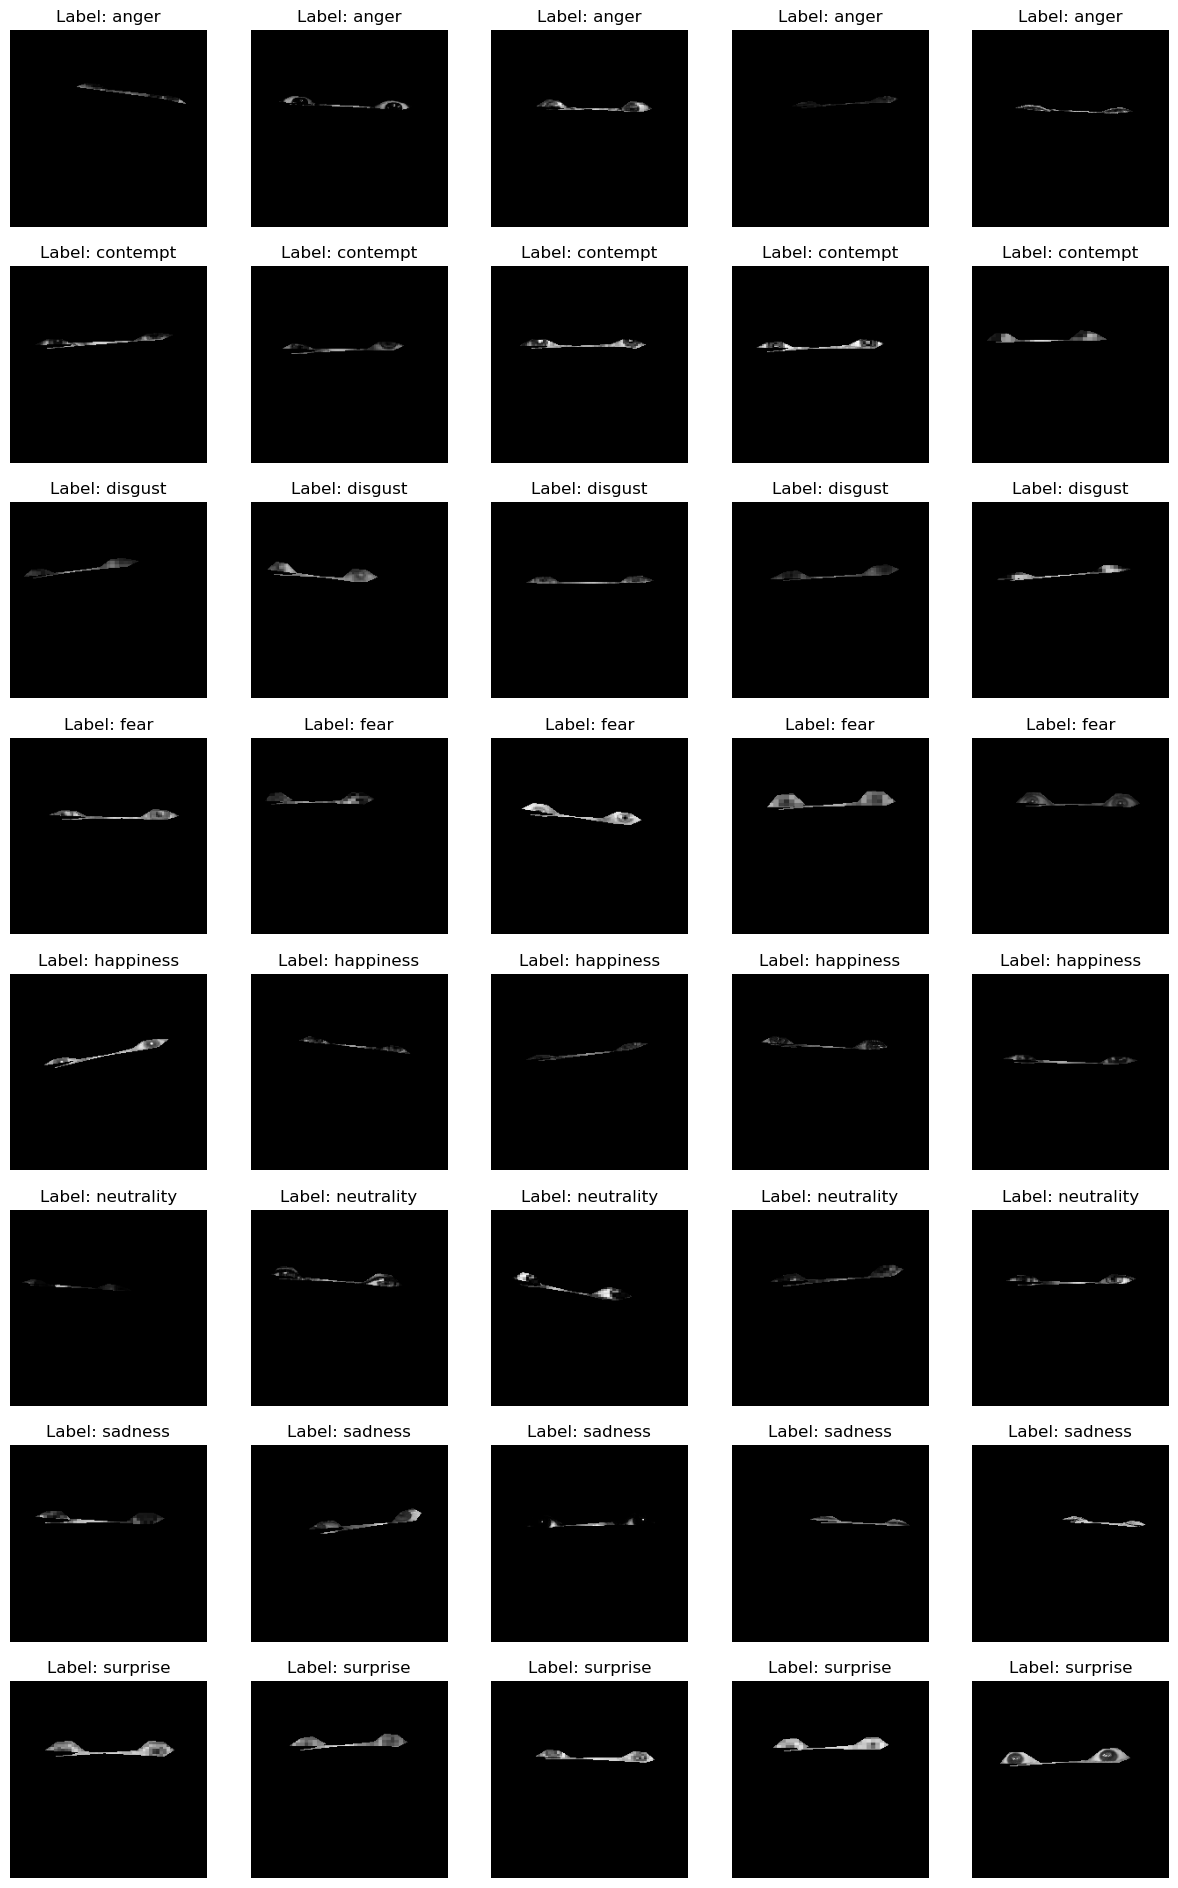

Label 0: 5 images
Label 1: 5 images
Label 2: 5 images
Label 3: 5 images
Label 4: 5 images
Label 5: 5 images
Label 6: 5 images
Label 7: 5 images


In [ ]:
def plot_first_n_images(images, labels, number):
    num_labels = len(set(labels))  # Get the number of unique labels
    num_rows = (number - 1) // 5 + 1  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows * num_labels, 5, figsize=(15, 3 * num_rows * num_labels))

    label_counts = defaultdict(int)  # Keep track of the count for each label

    for i, unique_label in enumerate(set(labels)):
        images_for_label = [(img, img_label) for img, img_label in zip(images, labels) if img_label == unique_label]
        for j in range(5):
            index = i * 5 + j
            if index < number*num_labels and j < len(images_for_label):
                img, img_label = images_for_label[j]
                axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(f"Label: {classeses[img_label]}")
                axes[i, j].axis('off')

                # Increment the count for the current label
                label_counts[img_label] += 1

    plt.show()

    # Print the count for each label
    for label, count in label_counts.items():
        print(f"Label {label}: {count} images")

# Example usage
plot_first_n_images(eyes_images, eyes_labels, 5)

Load data for each part of face(eyes, eyebrow, and mouth)

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])

# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

# Prepare datasets for eyes, eyebrows, and mouth
eye_dataset = prepare_dataset(eyes_images, eyes_labels, transform)
eyebrow_dataset = prepare_dataset(eyebrows_images, eyebrows_labels, transform)
mouth_dataset = prepare_dataset(mouth_images, mouth_labels, transform)

# split your datasets into training, validation, and test sets with a 60-20-20 percent ratio,
def split_dataset(dataset, train_percent=0.60, val_percent=0.20):
    total_size = len(dataset)
    train_size = int(total_size * train_percent)
    val_size = int(total_size * val_percent)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

# Prepare datasets for eyes, eyebrows, and mouth
eye_dataset = prepare_dataset(eyes_images, eyes_labels, transform)
eyebrow_dataset = prepare_dataset(eyebrows_images, eyebrows_labels, transform)
mouth_dataset = prepare_dataset(mouth_images, mouth_labels, transform)

# Split each dataset into training, validation, and test sets
eye_train_dataset, eye_val_dataset, eye_test_dataset = split_dataset(eye_dataset)
eyebrow_train_dataset, eyebrow_val_dataset, eyebrow_test_dataset = split_dataset(eyebrow_dataset)
mouth_train_dataset, mouth_val_dataset, mouth_test_dataset = split_dataset(mouth_dataset)

# Create DataLoaders for training and validation for each region
eye_train_loader = DataLoader(eye_train_dataset, batch_size=64, shuffle=True)
eye_val_loader = DataLoader(eye_val_dataset, batch_size=64, shuffle=False)

eyebrow_train_loader = DataLoader(eyebrow_train_dataset, batch_size=64, shuffle=True)
eyebrow_val_loader = DataLoader(eyebrow_val_dataset, batch_size=64, shuffle=False)

mouth_train_loader = DataLoader(mouth_train_dataset, batch_size=64, shuffle=True)
mouth_val_loader = DataLoader(mouth_val_dataset, batch_size=64, shuffle=False)

Model

In [14]:
# Model for eyes, eyebrows, and mouth regions
class RegionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(RegionCNN, self).__init__()
        self.name = "RegionCNN"
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),  # Adjust size as needed based on  dimensions
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_feature_vector=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = F.relu(self.classifier[0](x))  # First fully connected layer + ReLU
        feature_vector = F.relu(self.classifier[1](x))  # Second fully connected layer + ReLU

        if return_feature_vector:
            return feature_vector  # Return the feature vector before the final classification layer

        x = self.classifier[2](feature_vector)  # Final classification layer
        return x

# Final model for expression classification
class FinalExpressionCNN(nn.Module):
    def __init__(self, num_classes, combined_feature_size, dropout_rate=0.25):
        super(FinalExpressionCNN, self).__init__()
        self.name = "FinalExpressionCNN"
        
        self.features = nn.Sequential(
            nn.Conv2d(combined_feature_size, 64, kernel_size=3, padding=1),  # combined_feature_size include the depth of concatenated feature maps
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 1024),  # Adjust size as needed based on input dimensions
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x, eyebrow_features, eye_features, mouth_features):
        # Concatenate the features from the region-specific CNNs with the full face input
        combined_features = torch.cat((x, eyebrow_features, eye_features, mouth_features), dim=1)
        combined_features = self.features(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)
        x = self.classifier(combined_features)
        return x

# Example usage
num_classes = 8
combined_feature_size = 1 + 3 * 128  # 1 for grayscale image, 128 for each of the 3 features
eyebrow_model = RegionCNN(num_classes)
eye_model = RegionCNN(num_classes)
mouth_model = RegionCNN(num_classes)
final_model = FinalExpressionCNN(num_classes, combined_feature_size)

In [19]:
class RegionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super(RegionCNN, self).__init__()
        self.name = "RegionCNN"
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),  # Adjust size as needed based on  dimensions
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_feature_vector=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = F.relu(self.classifier[0](x))  # First fully connected layer + ReLU
        feature_vector = F.relu(self.classifier[1](x))  # Second fully connected layer + ReLU

        if return_feature_vector:
            return feature_vector  # Return the feature vector before the final classification layer

        x = self.classifier[2](feature_vector)  # Final classification layer
        return x

# Final model for expression classification
class FinalExpressionCNN(nn.Module):
    def __init__(self, num_classes, combined_feature_size, dropout_rate=0.25):
        super(FinalExpressionCNN, self).__init__()
        self.name = "FinalExpressionCNN"
        
        self.features = nn.Sequential(
            nn.Conv2d(combined_feature_size, 64, kernel_size=3, padding=1),  # combined_feature_size include the depth of concatenated feature maps
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 1024),  # Adjust size as needed based on input dimensions
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x, eyebrow_features, eye_features, mouth_features):
        # Concatenate the features from the region-specific CNNs with the full face input
        combined_features = torch.cat((x, eyebrow_features, eye_features, mouth_features), dim=1)
        combined_features = self.features(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)
        x = self.classifier(combined_features)
        return x

# Example usage
num_classes = 8
combined_feature_size = 1 + 3 * 128  # 1 for grayscale image, 128 for each of the 3 features
eyebrow_model = RegionCNN(num_classes)
eye_model = RegionCNN(num_classes)
mouth_model = RegionCNN(num_classes)
final_model = FinalExpressionCNN(num_classes, combined_feature_size)

Train Region-Specific CNNs (RegionCNN):
Train the RegionCNN models separately for each facial region (eyes, eyebrows, mouth) using the corresponding part of the face images.


In [11]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [12]:
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.01, num_epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'C:/Users/Admin/Desktop/MIE1517_Project/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.6f}, Train Loss: {train_losses[epoch]:.6f} | "
              f"Val Acc: {validation_accuracy[epoch]:.6f}, Val Loss: {validation_losses[epoch]:.6f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

Training Begin...

Epoch 1: Train Acc: 0.324156, Train Loss: 4.086621 | Val Acc: 0.298667, Val Loss: 3.952609
Epoch 2: Train Acc: 0.319716, Train Loss: 3.534553 | Val Acc: 0.333333, Val Loss: 3.960004
Epoch 3: Train Acc: 0.317496, Train Loss: 3.653978 | Val Acc: 0.321333, Val Loss: 4.191104
Epoch 4: Train Acc: 0.337478, Train Loss: 3.542902 | Val Acc: 0.282667, Val Loss: 3.914899
Epoch 5: Train Acc: 0.331261, Train Loss: 3.467401 | Val Acc: 0.310667, Val Loss: 3.838054
Epoch 6: Train Acc: 0.364565, Train Loss: 3.458247 | Val Acc: 0.321333, Val Loss: 3.577433
Epoch 7: Train Acc: 0.375666, Train Loss: 3.493383 | Val Acc: 0.333333, Val Loss: 3.743958
Epoch 8: Train Acc: 0.392984, Train Loss: 3.309357 | Val Acc: 0.324000, Val Loss: 3.837565
Epoch 9: Train Acc: 0.402753, Train Loss: 3.291622 | Val Acc: 0.314667, Val Loss: 3.815341
Epoch 10: Train Acc: 0.423179, Train Loss: 3.356375 | Val Acc: 0.333333, Val Loss: 3.888354
Epoch 11: Train Acc: 0.447158, Train Loss: 3.263279 | Val Acc: 0.32666

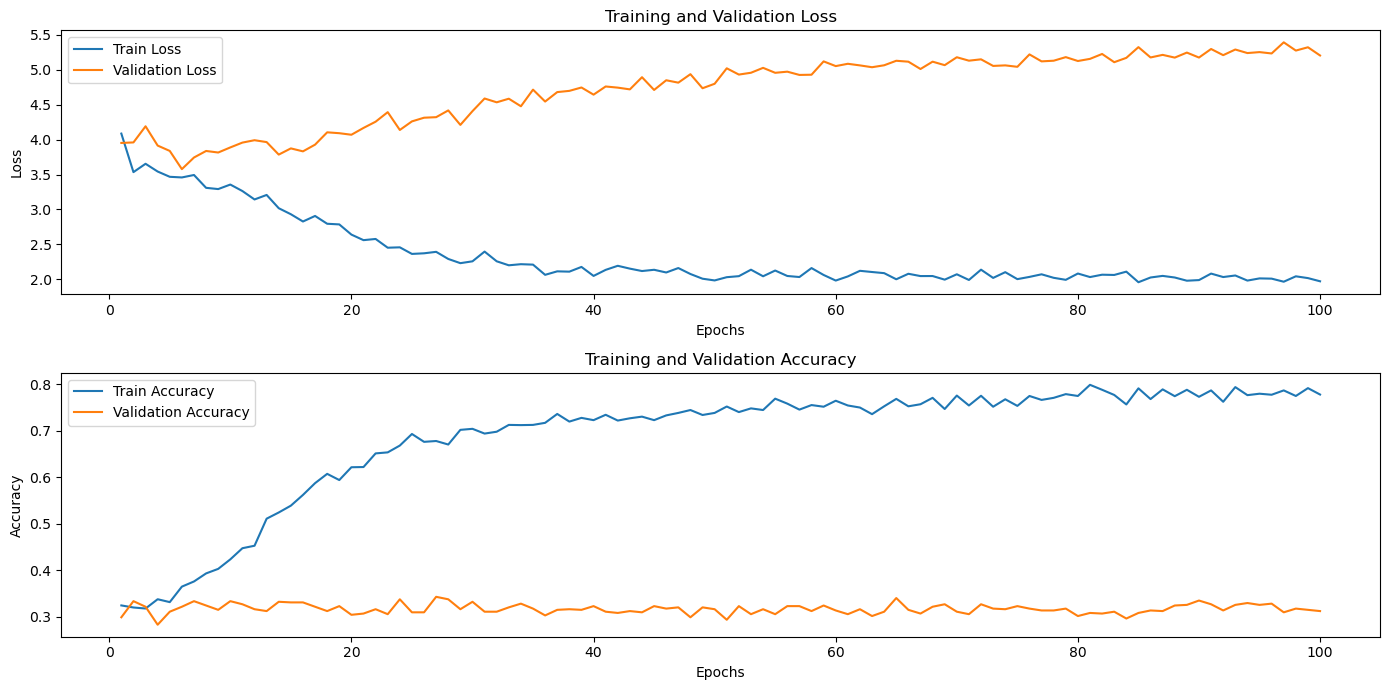

In [12]:
use_cuda = True
eye_model = eye_model.cuda()
eyebrow_model = eyebrow_model.cuda()
mouth_model = mouth_model.cuda()
eye_training = trainmodel(eye_model, eye_train_dataset, eye_val_dataset, batch=64, learningRate=0.001)

Training Begin...

Epoch 1: Train Acc: 0.226021, Train Loss: 5.313003 | Val Acc: 0.221333, Val Loss: 5.246884
Epoch 2: Train Acc: 0.234458, Train Loss: 4.964155 | Val Acc: 0.221333, Val Loss: 5.334969
Epoch 3: Train Acc: 0.214476, Train Loss: 5.020083 | Val Acc: 0.236000, Val Loss: 5.447155
Epoch 4: Train Acc: 0.255329, Train Loss: 4.980652 | Val Acc: 0.221333, Val Loss: 5.303452
Epoch 5: Train Acc: 0.264210, Train Loss: 4.903403 | Val Acc: 0.240000, Val Loss: 5.178642
Epoch 6: Train Acc: 0.261545, Train Loss: 4.893467 | Val Acc: 0.245333, Val Loss: 5.168726
Epoch 7: Train Acc: 0.246448, Train Loss: 4.881454 | Val Acc: 0.240000, Val Loss: 5.253604
Epoch 8: Train Acc: 0.265986, Train Loss: 4.885329 | Val Acc: 0.213333, Val Loss: 5.189057
Epoch 9: Train Acc: 0.276643, Train Loss: 4.808450 | Val Acc: 0.234667, Val Loss: 5.138793
Epoch 10: Train Acc: 0.280639, Train Loss: 4.845155 | Val Acc: 0.221333, Val Loss: 5.386064
Epoch 11: Train Acc: 0.313499, Train Loss: 4.776552 | Val Acc: 0.23066

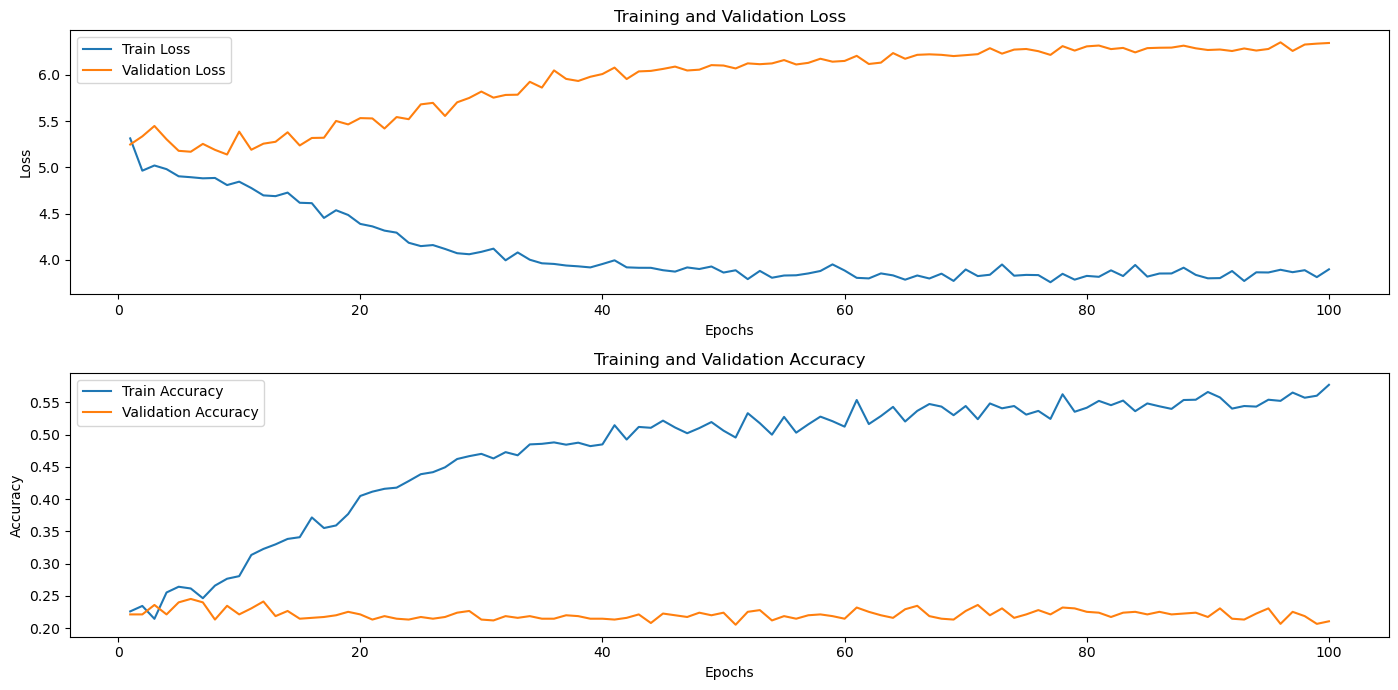

In [13]:
eyebrow_training = trainmodel(eyebrow_model, eyebrow_train_dataset, eyebrow_val_dataset, batch=64, learningRate=0.001)

Training Begin...

Epoch 1: Train Acc: 0.278863, Train Loss: 3.411512 | Val Acc: 0.280000, Val Loss: 3.685242
Epoch 2: Train Acc: 0.315719, Train Loss: 3.145629 | Val Acc: 0.332000, Val Loss: 3.264441
Epoch 3: Train Acc: 0.348579, Train Loss: 3.051623 | Val Acc: 0.328000, Val Loss: 3.180537
Epoch 4: Train Acc: 0.344583, Train Loss: 2.960362 | Val Acc: 0.328000, Val Loss: 3.070906
Epoch 5: Train Acc: 0.377442, Train Loss: 3.004693 | Val Acc: 0.373333, Val Loss: 3.276585
Epoch 6: Train Acc: 0.437833, Train Loss: 2.927659 | Val Acc: 0.357333, Val Loss: 3.338969
Epoch 7: Train Acc: 0.462700, Train Loss: 2.930546 | Val Acc: 0.354667, Val Loss: 3.367774
Epoch 8: Train Acc: 0.495560, Train Loss: 2.767139 | Val Acc: 0.378667, Val Loss: 3.131205
Epoch 9: Train Acc: 0.514654, Train Loss: 2.790957 | Val Acc: 0.381333, Val Loss: 3.284026
Epoch 10: Train Acc: 0.535968, Train Loss: 2.640682 | Val Acc: 0.376000, Val Loss: 3.327636
Epoch 11: Train Acc: 0.552398, Train Loss: 2.601336 | Val Acc: 0.37600

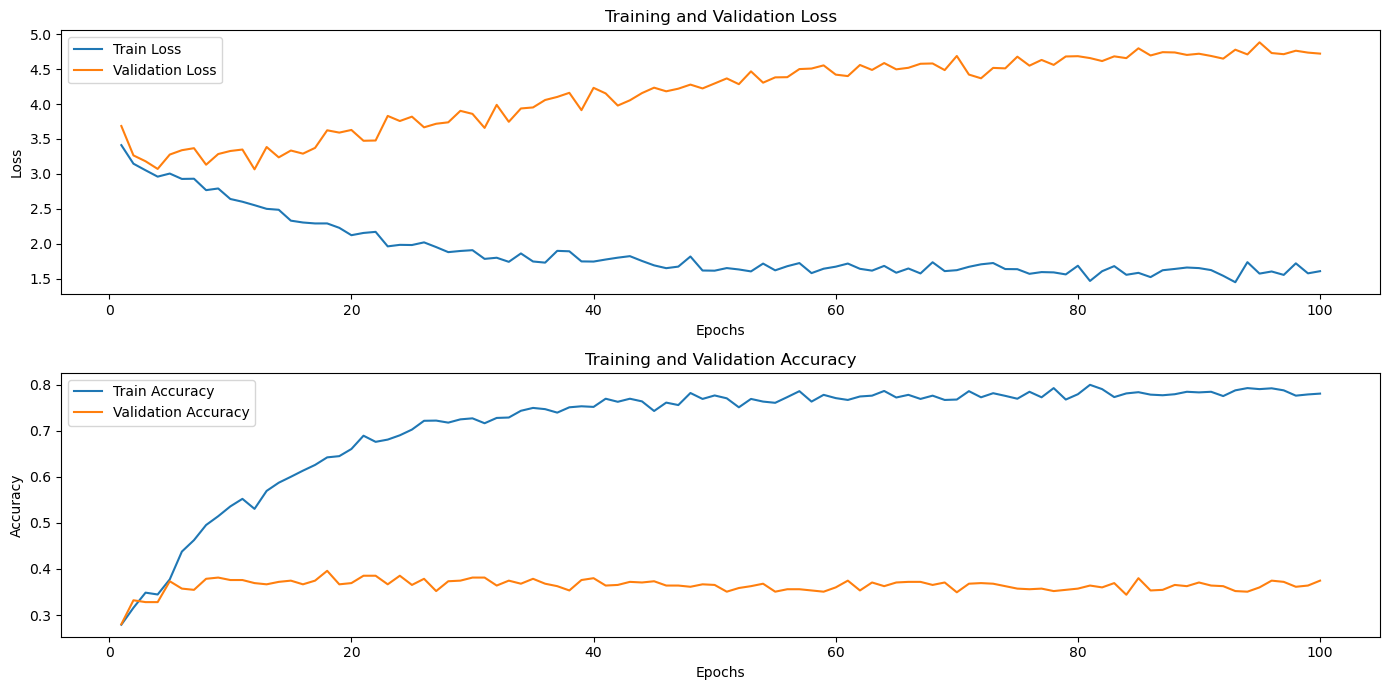

In [15]:
mouth_training = trainmodel(mouth_model, mouth_train_dataset, mouth_val_dataset, batch=64, learningRate=0.001)

Extract Features Using Trained RegionCNNs

Once each RegionCNN is trained, use them to extract features from their respective regions on the training dataset. This means running each region image through its corresponding RegionCNN and saving the output features (just before the final classification layer).
These features are what the FinalExpressionCNN will use, so you need to save them in a format that can be used for further training.

In [ ]:
def extract_features(model, loader):
    model.eval()  # Set the model to evaluation mode
    features = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, _ in loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            feature_vector = model(inputs, return_feature_vector=True)
            features.append(feature_vector.cpu())  # If using GPU, move to CPU
    return torch.cat(features)  # Concatenate all features into a single tensor

In [ ]:
#training feature
eye_features_train = extract_features(eye_model, eye_train_loader)
eyebrow_features_train = extract_features(eyebrow_model, eyebrow_train_loader)
mouth_features_train = extract_features(mouth_model, mouth_train_loader)
#validation feature
eye_features_val = extract_features(eye_model, eye_val_loader)
eyebrow_features_val = extract_features(eyebrow_model, eyebrow_val_loader)
mouth_features_val = extract_features(mouth_model, mouth_val_loader)

Combine Extracted Features:
Combine the extracted features from each RegionCNN into a single, larger feature vector for each image.

In [ ]:
def combine_features(eye_features, eyebrow_features, mouth_features):
    combined = torch.cat((eye_features, eyebrow_features, mouth_features), dim=1)
    return combined


In [ ]:
combine_features_train = combine_features(eye_features_val, eyebrow_features_val, mouth_features_val)
combine_features_val = combine_features(eye_features_val, eyebrow_features_val, mouth_features_val)

Train FinalExpressionCNN:
Use these combined feature vectors as input to FinalExpressionCNN.
Train FinalExpressionCNN to classify expressions based on the combined feature

In [ ]:
combined_labels = torch.tensor(labels_or) #根据guojin的code来的 可能实际测试的时候要改一下

# Create a new TensorDataset for combined features and labels
combined_train_dataset = torch.utils.data.TensorDataset(combine_features_train, combined_labels)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)

# validation dataset

combined_val_dataset = torch.utils.data.TensorDataset(combine_features_val, combined_labels) # create combined dataset for validation
combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)

# Train the final model using the combined datasets
final_training = trainmodel(final_model, combined_train_loader, combined_val_loader, batch=64, learningRate=0.01, num_epochs=300)

Full System Inference:
In the operational phase, when run inference to predict expressions, I will pass the new image through each RegionCNN to extract features and then through the FinalExpressionCNN to get the final expression classification.

In [ ]:
# 可以先不管这个part， 这个是给新的dataset用的

def full_system_inference(models, final_model, image):
    # Assume `models` is a list of trained region-specific models in the order: [eye_model, eyebrow_model, mouth_model]
    features = []
    for model in models:
        region = extract_region_from_image(image, model.region)  # This function needs to be implemented
        feature = extract_features(model, region)
        features.append(feature)

    combined_feature = combine_features(*features)
    final_output = final_model(combined_feature.unsqueeze(0))  # Add batch dimension
    return final_output